### Bayesian data analysis
##  Chapter 11, demo 1

Gibbs sampling demonstration

First we import required libraries and tune some settings

In [1]:
import numpy as np
from scipy import linalg, stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
import arviz as az

In [2]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)

## Example 1

We create a two dimensional normal distribution to be used as an example target distribution. We also define the starting values for the Gibbs sampling here.

In [4]:
# parameters of a two dimensional Normal distribution used as a toy target distribution
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
r = 0.8  # covariance between the first and second dimension
S = np.array([[1.0, r], [r, 1.0]]) # covariance within both dimensions is 1.0

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension
# number of iterations.
M = 2*1000
# N.B. In this implementation one iteration updates only one parameter and one
# complete iteration updating both parameters takes two basic iterations. This
# implementation was used to make plotting of Gibbs sampler's zig-zagging. In
# plots You can implement this also by saving only the final state of complete
# iteration updating all parameters.

Next we apply Gibbs sampling to sample the generated two dimensional normal distribution. We sample from the toy distribution to visualize 90% HPD (Highest Posterior Density) interval. See BDA3 p. 85 for how to compute HPD for a multivariate normal distribution. In 2d-case contour for 90% HPD is an ellipse, whose semimajor axes can be computed from the eigenvalues of the covariance matrix scaled by a value selected to get ellipse match the density at the edge of 90% HPD. Angle of the ellipse could be computed from the eigenvectors, but since the marginals are same we know that angle is pi/4.

In [5]:
# Gibbs sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# For demonstration, load pre-computed values.
# Replace this with your algorithm!
# tt is a M x 2 array, with M samples of both theta_1 and theta_2
res_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'demo11_2.npz'
    )
)
res = np.load(res_path)
tt = res['tt']
res.close()
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))

loaded pre-computed values in variable `tt`
shape:(2001, 2), dtype:float64


The rest is just for illustration. We first calculate the 90% HPD using the covariance matrix.

In [6]:
# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

# number of samples to discard from the beginning
burnin = 50 * 2 # Using burnin of 100 will actually remove only 50 samples as only one parameter is updated in one basic iteration

# Plot 90% HPD.
# In 2d-case contour for 90% HPD is an ellipse, whose semimajor
# axes can be computed from the eigenvalues of the covariance
# matrix scaled by a value selected to get ellipse match the
# density at the edge of 90% HPD. Angle of the ellipse could be 
# computed from the eigenvectors, but since marginals are same
# we know that angle is 45 degrees.
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) # 2.147 is the value to get the ellipse match the 
                                                                # density at the edge of 90% HPD

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

We show the sequential progress of the sampling for the first 50 samples. These 50 samples are then removed as burnin from the final samples. Finally we also plot the rest of the samples that remain after the burnin has been removed.

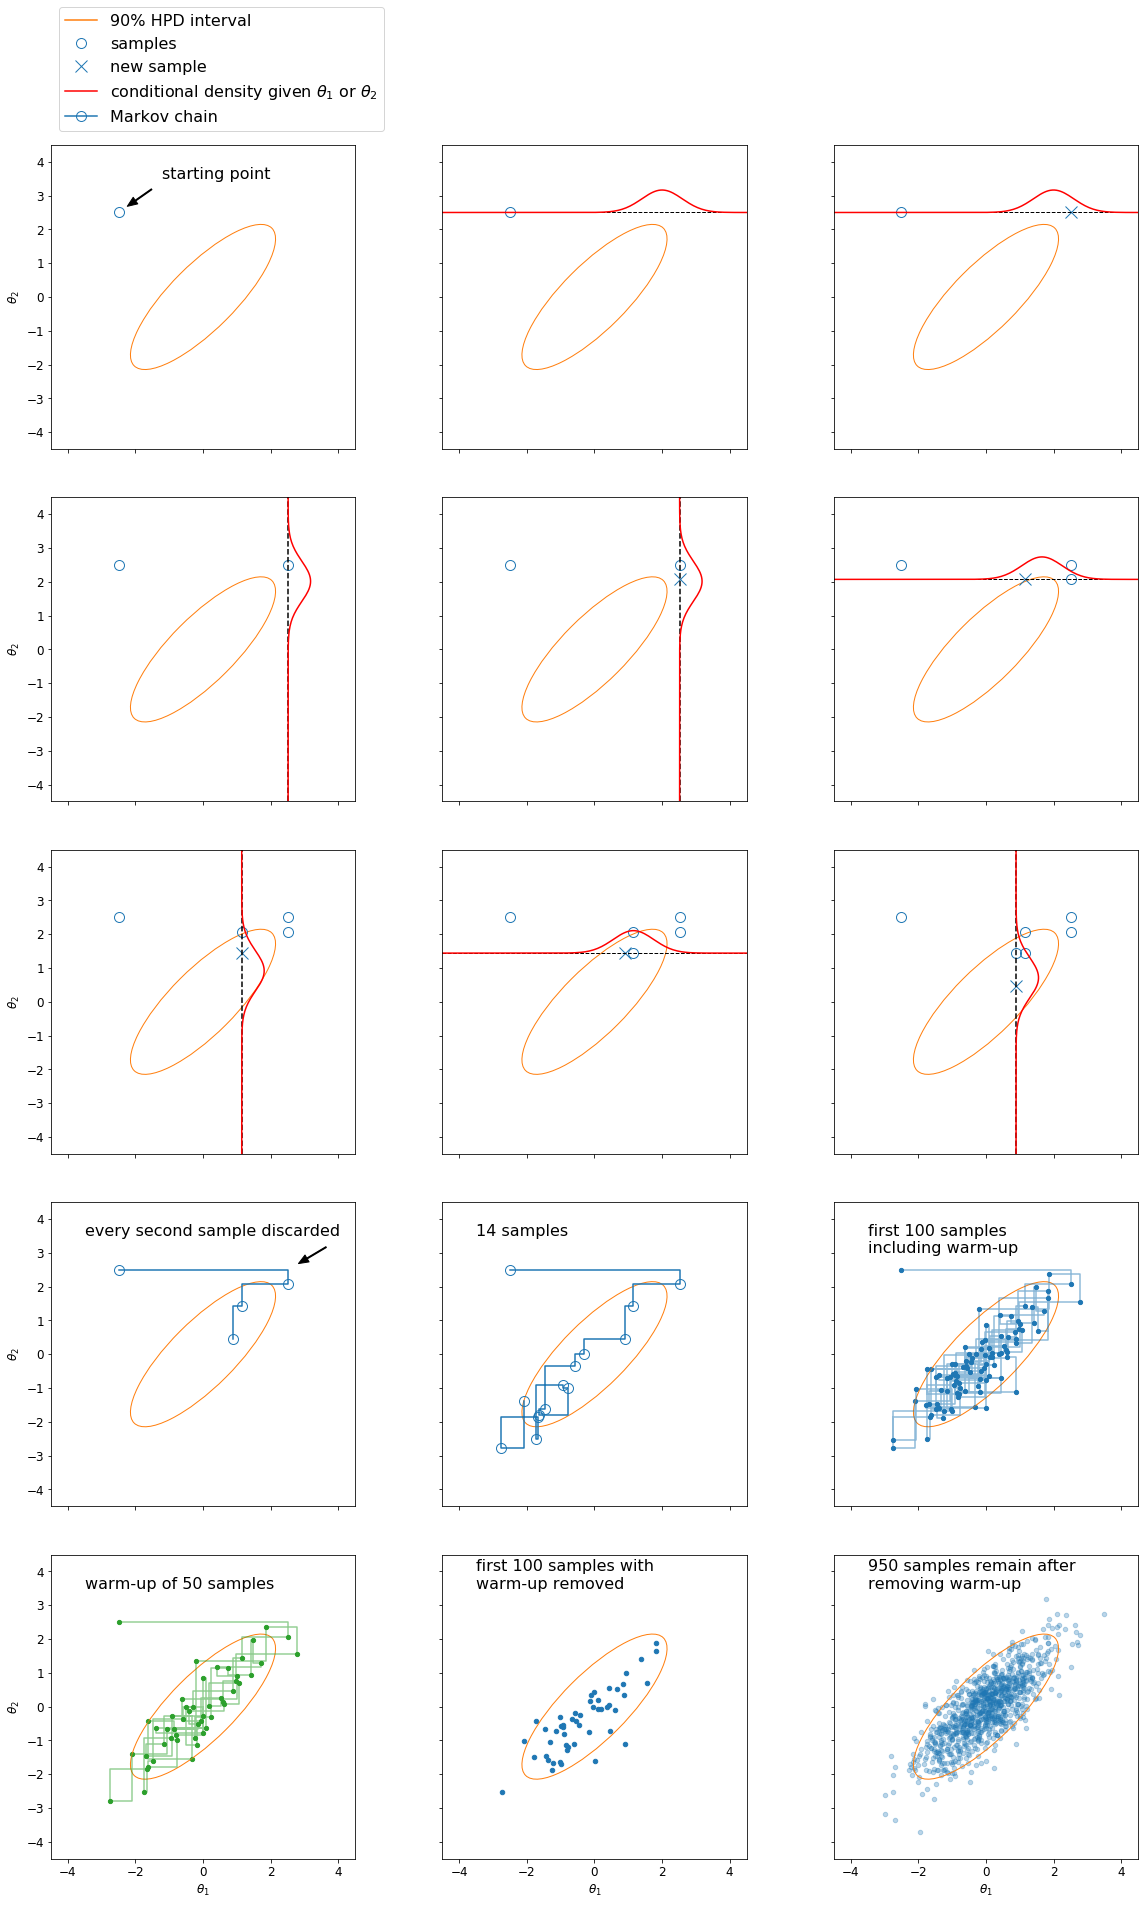

In [7]:
# create the plots
subplotshape = (5, 3)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(16,27), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], linestyle='', marker='x', markersize=12,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='r'),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'new sample',
        r'conditional density given $\theta_{1}$ or $\theta_{2}$',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)

# FIRST SUBPLOT
ax = axes[0,0] #choosing the correct subplot for plotting
add90hpd(ax) #plotting the 90% HPD ellipse that was defined earlier

#plotting the starting point
ax.plot(
    tt[0,0], tt[0,1], 'o', markersize=10,  
    markerfacecolor='none', markeredgecolor='C0'
)

#Plotting an arrow to highlight the starting point
ax.annotate(          
    'starting point',
    (tt[0,0], tt[0,1]),
    (-1.2, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# SECOND SUBPLOT
ax = axes[0,1] #choosing the correct subplot for plotting
add90hpd(ax) #plotting the 90% HPD ellipse that was defined earlier

# plot the older samples
i = 0 #variable to denote the index until which we plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) # a zero-density baseline for the conditional density
# plotting the conditional density given theta1 or theta2
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

# THIRD SUBPLOT
ax = axes[0,2]
add90hpd(ax)
i = 0 #variable to denote the index until which we plot the older samples
# plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
# plot the next new sample
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) # a zero-density baseline for the conditional density
# plotting the conditional density given theta1 or theta2
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

# FOURTH SUBPLOT
ax = axes[1,0]
add90hpd(ax)
i = 1 #variable to denote the index until which we plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# FIFTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
i = 1
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# SIXTH SUBPLOT
ax = axes[1,2]
add90hpd(ax)
i = 2
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

# SEVENTH SUBPLOT
ax = axes[2,0]
add90hpd(ax)
i = 3
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# EIGHTH SUBPLOT
ax = axes[2,1]
add90hpd(ax)
i = 4
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

#NINTH SUBPLOT
ax = axes[2,2]
add90hpd(ax)
i = 5
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# TENTH SUBPLOT
ax = axes[3,0]
add90hpd(ax)
i = 6
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')

#plot arrow marker and text
ax.annotate(
    'every second sample discarded',
    (tt[1,0], tt[1,1]),
    (-3.5, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# ELEVENTH SUBPLOT
ax = axes[3,1]
add90hpd(ax)
i = 26
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '14 samples', fontsize=16)

# TWELVTH SUBPLOT
ax = axes[3,2]
add90hpd(ax)
i = 198
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1:2,0], tt[:i+1:2,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 100 samples\nincluding warm-up', fontsize=16)

#THIRTEENTH SUBPLOT
ax = axes[4,0]
add90hpd(ax)
i = 198
# plotting warm-up
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin:2,0], tt[:burnin:2,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 50 samples', fontsize=16)

# FOURTEENTH SUBPLOT
ax = axes[4,1]
add90hpd(ax)
i = 198
ax.scatter(
    tt[burnin:i+1:2,0], tt[burnin:i+1:2,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 100 samples with\nwarm-up removed', fontsize=16)

# FIFTEENTH SUBPLOT
ax = axes[4,2]
add90hpd(ax)
ax.scatter(
    tt[burnin::2,0], tt[burnin::2,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '950 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

Looking at the last sublot showing the 950 samples after removing warm-up, we can see that the sampling seems to have sampled the target distribution quite well. All of the 90% HPD area is sampled and also about 10% of the samples seem to fall outside of the 90% HPD.

We'll next plot an animation showing the first 50 samples of the Gibbs sampling. This animation requires ffmpeg in order to work properly. If you need to install ffmpeg, the instructions can be found at https://www.wikihow.com/Install-FFmpeg-on-Windows. If the animation doesn't play correctly, you can also find the animation from the same folder as this demo with the filename "gibbssampler1.mp4".

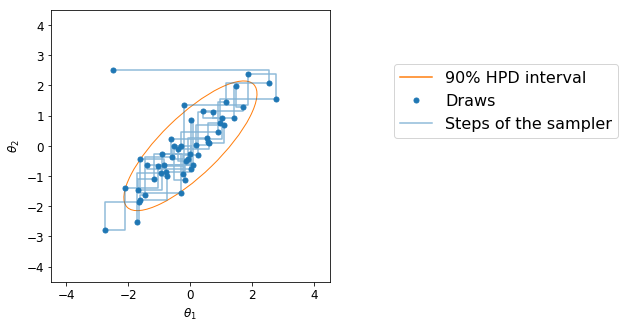

In [8]:
# First set up the figure, the axis and the axis labels
fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-4.5, 4.5), ylim=(-4.5, 4.5))
ax.set_ylabel(r'$\theta_2$')
ax.set_xlabel(r'$\theta_1$')

# Plot a legend
ax.legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=5,
            markerfacecolor='C0', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='C0', alpha=0.5),
    ),
    (   '90% HPD interval',
        'Draws',
        'Steps of the sampler'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(1.2, 0.5, 0, 0),
    fontsize=16
)

# Initialize styles for the lines and points to be plotted. At this point the lines and points have no data.
line, = ax.plot([], [], color='C0', alpha=0.5)
point, = ax.plot([], [],'.', markersize=10, lw=0, markerfacecolor='C0', markeredgecolor='C0')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    point.set_data([], [])
    return (line,point,)


add90hpd(ax) #draw the 90% HPD

#choose only the warmup samples
warmup1 = tt[:burnin,0]
warmup2 = tt[:burnin,1]


# animation function. This is called sequentially
def animate(i):
    x = warmup1[:i] #choose points until i
    y = warmup2[:i] #choose points until i
    line.set_data(x, y) #draw lines between all points  
    point.set_data(x[::2], y[::2]) #draw points only for every other sample pair
    return (line,point,)

# choose the animation writer. If you don't have ffmpeg installed you can change this to some writer that you already have.
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=200, blit=True)

# show the animation as a html5 video to allow showing it in an iPython notebook
try:
    display(HTML(anim.to_html5_video()))
except:
    display(HTML("""<video width="360" height="360" controls><source src="gibbssampler1.mp4" type="video/mp4"></video>"""))

# Uncomment below to save the animation as an mp4-file


# #Save the movie file
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('gibbssampler1.mp4', writer=writer)




## Visual convergence diagnostics

Here we plot the behavior of theta1 and theta2 separately. We also plot the cumulative average and autocorrelation for theta1 and theta2 samples separately to visually see the convergence.

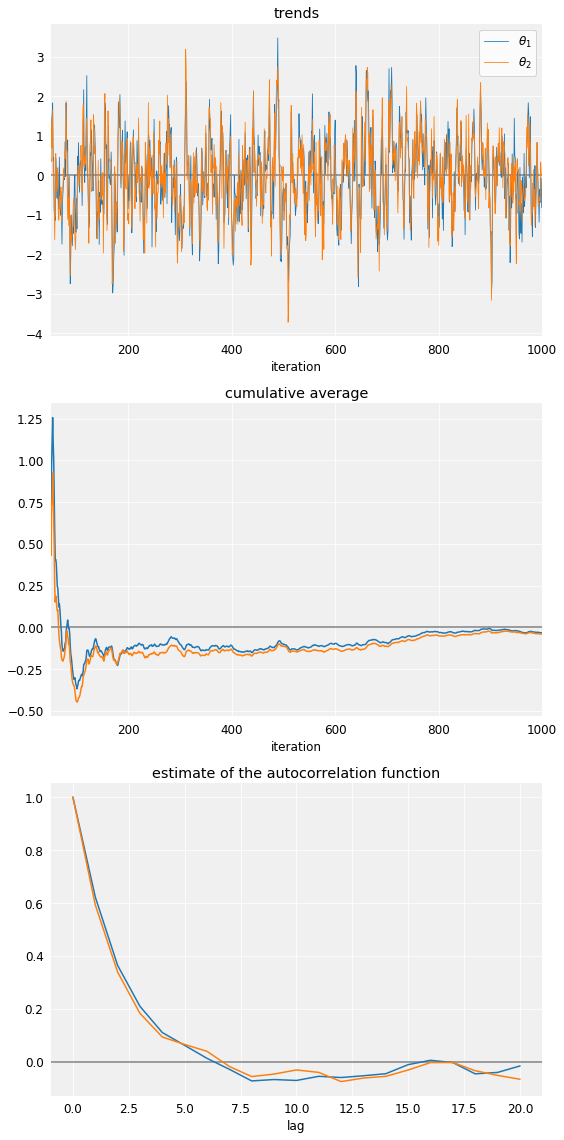

In [9]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes/2, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin/2, 1000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes/2,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin/2, 1000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

Looking at the trends we can see that the sampling moves around the distribution quite rapidly. Looking at the cumulative average we can see that the chains seem to converge. Looking at the estimated autocorrelation function we can see that there's not too much autocorrelation once the lag is increased.

Next we visualize the estimate of the Monte Carlo error estimates for the cumulative average plots.

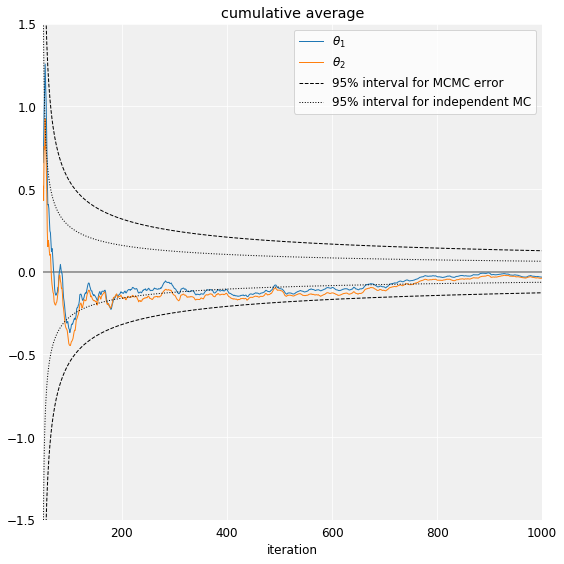

In [10]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M, 2)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes/2,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes/2, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes/2, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes/2, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes/2, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin/2, 1000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

The analysis and the generated samples both show that Gibbs sampling worked quite well for the target distribution that we used. Next we'll test the same Gibbs sampling for a more narrow two dimensional normal distribution.

## Example 2

Now our target distribution will be a two dimensional normal distribution with r = 0.99. This makes the distribution much narrower.

In [11]:
# parameters of a two dimensional Normal distribution used as a toy target distribution
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
r = 0.99  # covariance between the first and second dimension
S = np.array([[1.0, r], [r, 1.0]]) # covariance within both dimensions is 1.0

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension
# number of iterations.
M = 2*1000
# N.B. In this implementation one iteration updates only one parameter and one
# complete iteration updating both parameters takes two basic iterations. This
# implementation was used to make plotting of Gibbs sampler's zig-zagging. In
# plots You can implement this also by saving only the final state of complete
# iteration updating all parameters.

Next we apply Gibbs sampling to sample the generated two dimensional normal distribution. We sample from the toy distribution to visualize 90% HPD (Highest Posterior Density) interval. See BDA3 p. 85 for how to compute HPD for a multivariate normal distribution. In 2d-case contour for 90% HPD is an ellipse, whose semimajor axes can be computed from the eigenvalues of the covariance matrix scaled by a value selected to get ellipse match the density at the edge of 90% HPD. Angle of the ellipse could be computed from the eigenvectors, but since the marginals are same we know that angle is pi/4.

In [12]:
# Gibbs sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# For demonstration, load pre-computed values.
# Replace this with your algorithm!
# tt is a M x 2 array, with M samples of both theta_1 and theta_2
res_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'demo11_1b.csv'
    )
)
res = np.loadtxt(res_path, skiprows=1, usecols = (1,2), delimiter = ',')
tt = res
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))

loaded pre-computed values in variable `tt`
shape:(2001, 2), dtype:float64


The rest is just for illustration. We first calculate the 90% HPD using the covariance matrix.

In [13]:
# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

# number of samples to discard from the beginning
burnin = 50 * 2 # Using burnin of 100 will actually remove only 50 samples as only one parameter is updated in one basic iteration

# Plot 90% HPD.
# In 2d-case contour for 90% HPD is an ellipse, whose semimajor
# axes can be computed from the eigenvalues of the covariance
# matrix scaled by a value selected to get ellipse match the
# density at the edge of 90% HPD. Angle of the ellipse could be 
# computed from the eigenvectors, but since marginals are same
# we know that angle is 45 degrees.
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) # 2.147 is the value to get the ellipse match the 
                                                                # density at the edge of 90% HPD

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

We show the sequential progress of the sampling for the first 50 samples. These 50 samples are then removed as burnin from the final samples. Finally we also plot the rest of the samples that remain after the burnin has been removed.

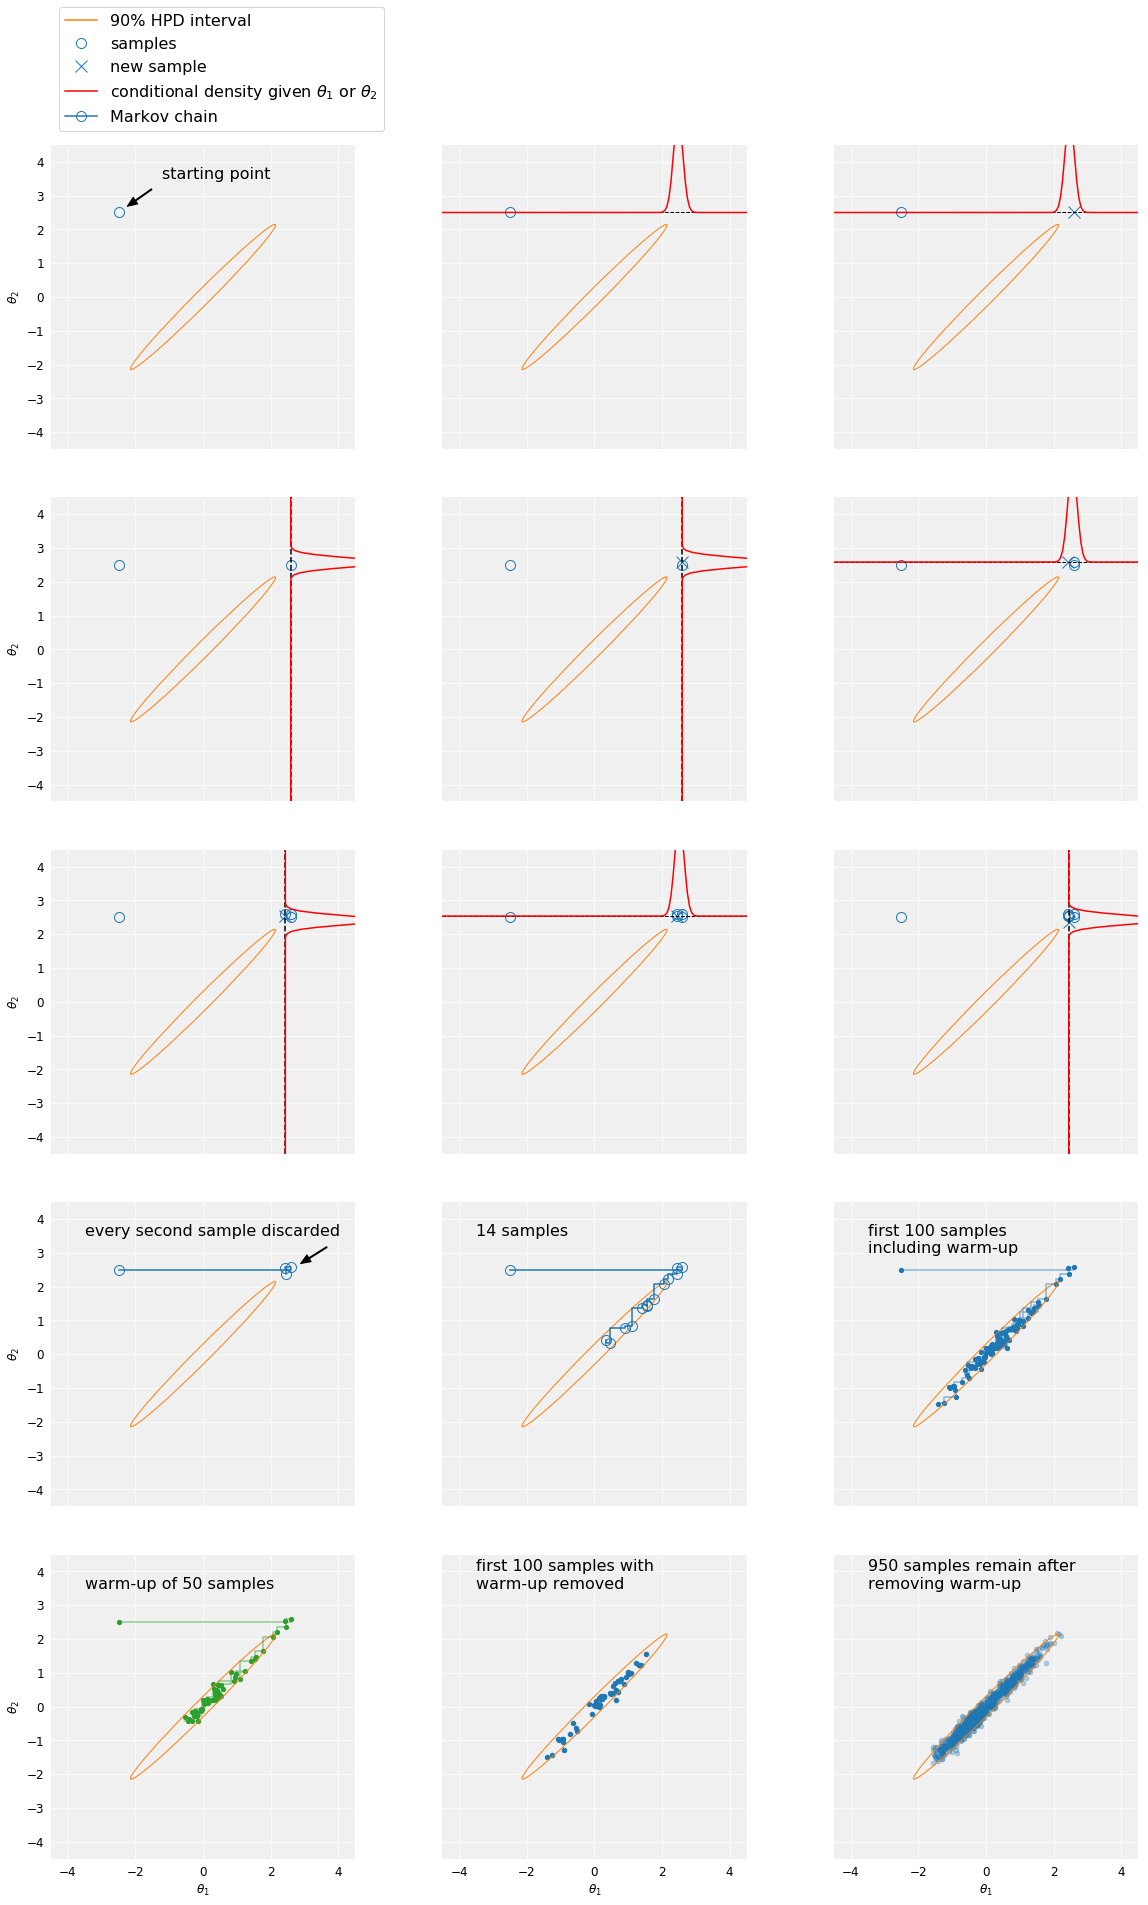

In [14]:
# create the plots
subplotshape = (5, 3)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(16,27), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], linestyle='', marker='x', markersize=12,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='r'),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'new sample',
        r'conditional density given $\theta_{1}$ or $\theta_{2}$',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)

# FIRST SUBPLOT
ax = axes[0,0] #choosing the correct subplot for plotting
add90hpd(ax) #plotting the 90% HPD ellipse that was defined earlier

#plotting the starting point
ax.plot(
    tt[0,0], tt[0,1], 'o', markersize=10,  
    markerfacecolor='none', markeredgecolor='C0'
)

#Plotting an arrow to highlight the starting point
ax.annotate(          
    'starting point',
    (tt[0,0], tt[0,1]),
    (-1.2, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# SECOND SUBPLOT
ax = axes[0,1] #choosing the correct subplot for plotting
add90hpd(ax) #plotting the 90% HPD ellipse that was defined earlier

# plot the older samples
i = 0 #variable to denote the index until which we plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) # a zero-density baseline for the conditional density
# plotting the conditional density given theta1 or theta2
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

# THIRD SUBPLOT
ax = axes[0,2]
add90hpd(ax)
i = 0 #variable to denote the index until which we plot the older samples
# plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
# plot the next new sample
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) # a zero-density baseline for the conditional density
# plotting the conditional density given theta1 or theta2
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

# FOURTH SUBPLOT
ax = axes[1,0]
add90hpd(ax)
i = 1 #variable to denote the index until which we plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# FIFTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
i = 1
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# SIXTH SUBPLOT
ax = axes[1,2]
add90hpd(ax)
i = 2
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

# SEVENTH SUBPLOT
ax = axes[2,0]
add90hpd(ax)
i = 3
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# EIGHTH SUBPLOT
ax = axes[2,1]
add90hpd(ax)
i = 4
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + r*(tt[i,1] - y2),
        scale = np.sqrt((1 - r**2))
    ),
    color = 'r'
)

#NINTH SUBPLOT
ax = axes[2,2]
add90hpd(ax)
i = 5
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + r*(tt[i,0] - y1),
        scale = np.sqrt((1 - r**2))
    ),
    Y2,
    color = 'r'
)

# TENTH SUBPLOT
ax = axes[3,0]
add90hpd(ax)
i = 6
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')

#plot arrow marker and text
ax.annotate(
    'every second sample discarded',
    (tt[1,0], tt[1,1]),
    (-3.5, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# ELEVENTH SUBPLOT
ax = axes[3,1]
add90hpd(ax)
i = 26
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '14 samples', fontsize=16)

# TWELVTH SUBPLOT
ax = axes[3,2]
add90hpd(ax)
i = 198
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1:2,0], tt[:i+1:2,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 100 samples\nincluding warm-up', fontsize=16)

#THIRTEENTH SUBPLOT
ax = axes[4,0]
add90hpd(ax)
i = 198
# plotting warm-up
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin:2,0], tt[:burnin:2,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 50 samples', fontsize=16)

# FOURTEENTH SUBPLOT
ax = axes[4,1]
add90hpd(ax)
i = 198
ax.scatter(
    tt[burnin:i+1:2,0], tt[burnin:i+1:2,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 100 samples with\nwarm-up removed', fontsize=16)

# FIFTEENTH SUBPLOT
ax = axes[4,2]
add90hpd(ax)
ax.scatter(
    tt[burnin::2,0], tt[burnin::2,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '950 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

Looking at the last sublot showing the 950 samples after removing warm-up, we can see that the sampling seems to have sampled the target distribution only partially. The lower left area of the 90% HPD is not sampled at all and also the upper right area of the 90% HPD seems to be only partially sampled.

We'll next plot an animation showing the first 50 samples of the Gibbs sampling. This animation requires ffmpeg in order to work properly. If you need to install ffmpeg, the instructions can be found at https://www.wikihow.com/Install-FFmpeg-on-Windows. If the animation doesn't play correctly, you can also find the animation from the same folder as this demo with the filename "gibbssampler2.mp4".

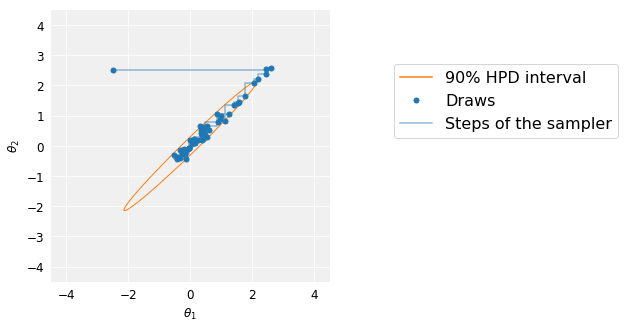

In [15]:
# First set up the figure, the axis and the axis labels
fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-4.5, 4.5), ylim=(-4.5, 4.5))
ax.set_ylabel(r'$\theta_2$')
ax.set_xlabel(r'$\theta_1$')

# Plot a legend
ax.legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=5,
            markerfacecolor='C0', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='C0', alpha=0.5),
    ),
    (   '90% HPD interval',
        'Draws',
        'Steps of the sampler'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(1.2, 0.5, 0, 0),
    fontsize=16
)

# Initialize styles for the lines and points to be plotted. At this point the lines and points have no data.
line, = ax.plot([], [], color='C0', alpha=0.5)
point, = ax.plot([], [],'.', markersize=10, lw=0, markerfacecolor='C0', markeredgecolor='C0')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    point.set_data([], [])
    return (line,point,)


add90hpd(ax) #draw the 90% HPD

#choose only the warmup samples
warmup1 = tt[:burnin,0]
warmup2 = tt[:burnin,1]


# animation function. This is called sequentially
def animate(i):
    x = warmup1[:i] #choose points until i
    y = warmup2[:i] #choose points until i
    line.set_data(x, y) #draw lines between all points  
    point.set_data(x[::2], y[::2]) #draw points only for every other sample pair
    return (line,point,)

# choose the animation writer. If you don't have ffmpeg installed you can change this to some writer that you already have.
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=200, blit=True)

# show the animation as a html5 video to allow showing it in an iPython notebook
try:
    display(HTML(anim.to_html5_video()))
except:
    display(HTML("""<video width="360" height="360" controls><source src="gibbssampler2.mp4" type="video/mp4"></video>"""))

# Uncomment below to save the animation as an mp4-file


# #Save the movie file
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('gibbssampler2.mp4', writer=writer)




## Visual convergence diagnostics

Here we plot the behavior of theta1 and theta2 separately. We also plot the cumulative average and autocorrelation for theta1 and theta2 samples separately to visually see the convergence.

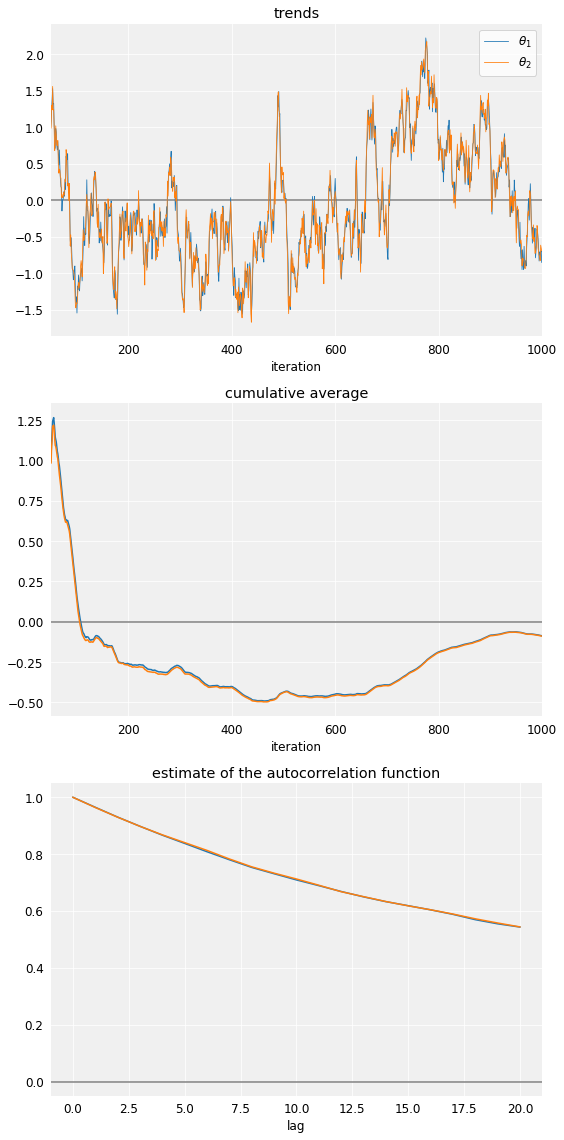

In [16]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes/2, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin/2, 1000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes/2,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin/2, 1000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

Looking at the trend curves we can see that the sampling moves around the target distribution quite slowly. Looking at the cumulative average we can see that the chains don't really converge well within the 1000 samples drawn. Looking at the estimated autocorrelation function we can see that significant autocorrelation remains until lag 20.

Next we visualize the estimate of the Monte Carlo error estimates for the cumulative average plots.

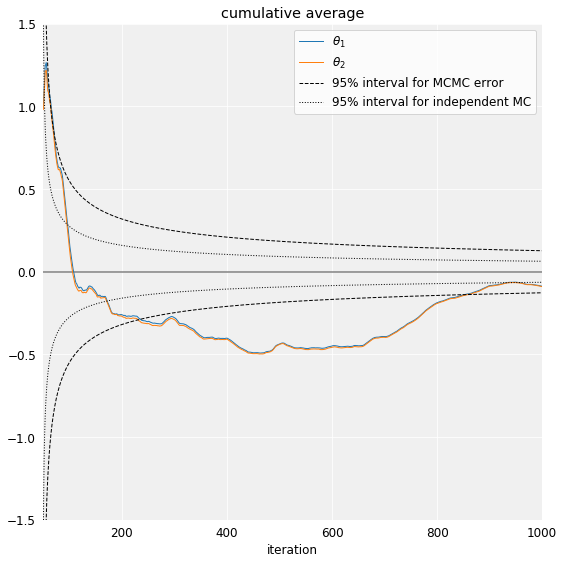

In [17]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M, 2)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes/2,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes/2, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes/2, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes/2, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes/2, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin/2, 1000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

The analysis and the generated samples both show that Gibbs sampling didn't work well for the chosen target distribution. For this target distribution we should consider some other sampling method instead.